In [7]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [8]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms

import torchinfo

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments
MODEL_NAME = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
PRETRAINED = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP


@dataclass
class Config:
    model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    pretrained: str = "laion2b_s34b_b79k"
    image_size: int = 224
    batch_size: int = 64
    num_workers: int = 4
    max_epochs: int = 5

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 1e-3
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 4

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50

cfg = Config()
cfg


Config(model_name='ViT-B-32', pretrained='laion2b_s34b_b79k', image_size=224, batch_size=64, num_workers=4, max_epochs=5, lr_base=1e-05, lr_prompt=0.001, weight_decay=0.05, unfreeze_layers=(), prompt_len=4, overfit_n_classes=2, overfit_k_per_class=8, overfit_epochs=50)

In [10]:
# --- Load model + preprocess ---
model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)
model = model.to(device).eval()

torchinfo.summary(model)

Layer (type:depth-idx)                                                 Param #
CLIP                                                                   301,569
├─VisionTransformer: 1-1                                               432,384
│    └─Conv2d: 2-1                                                     2,359,296
│    └─Identity: 2-2                                                   --
│    └─LayerNorm: 2-3                                                  1,536
│    └─Transformer: 2-4                                                --
│    │    └─ModuleList: 3-1                                            85,054,464
│    └─LayerNorm: 2-5                                                  1,536
├─Transformer: 1-2                                                     --
│    └─ModuleList: 2-6                                                 --
│    │    └─ResidualAttentionBlock: 3-2                                3,152,384
│    │    └─ResidualAttentionBlock: 3-3                              

Val dataset:   10000 images, 10 classes


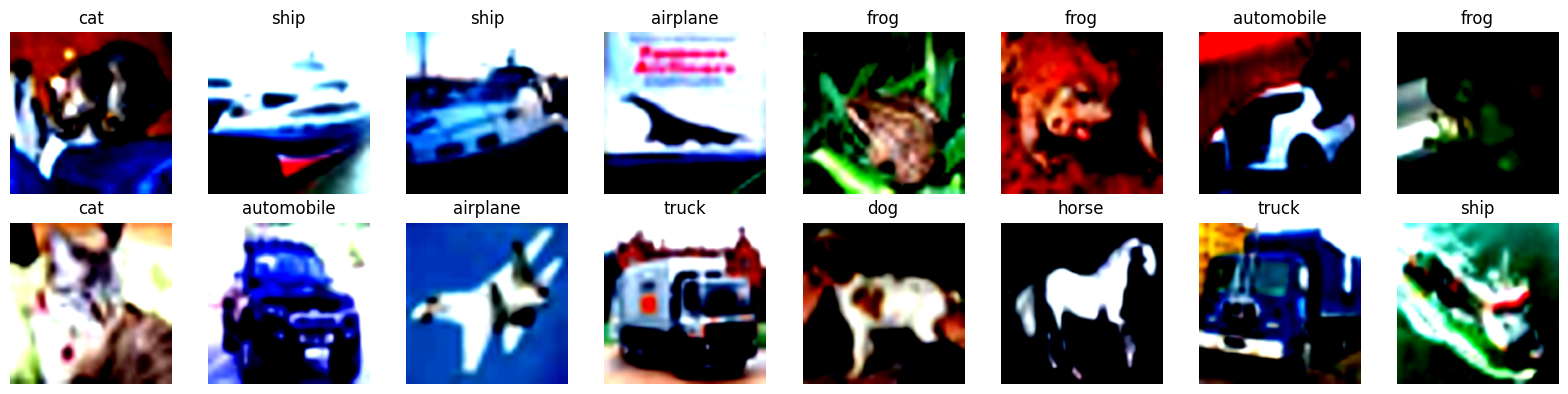

In [11]:
val_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=preprocess)

val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

classnames = val_ds.classes
num_classes = len(classnames)

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [12]:
prompts = [f"a photo of a {c}" for c in classnames]
with torch.no_grad():
    text_tokens   = tokenizer(prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

correct = total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        # CLIP-style scaled cosine sims
        logits = 100.0 * image_features @ text_features.T
        preds = logits.argmax(dim=-1).cpu()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Zero-shot CIFAR-10 accuracy: {100*correct/total:.2f}%")

Zero-shot CIFAR-10 accuracy: 93.66%


In [ ]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip_model, tokenizer, classnames, n_ctx=16, init_scale=0.02, device="cpu"):
        super().__init__()
        self.model = clip_model
        self.tokenizer = tokenizer
        self.classnames = classnames
        self.device = device

        # Text transformer sizes
        self.context_length = getattr(self.model, "context_length", 77)
        self.width = self.model.token_embedding.weight.shape[1]

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.class_token_ids = tokenizer(classnames).to(device)  # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.eot_indices = self.class_token_ids.argmax(dim=-1)   # [C]

        # Freeze CLIP
        for p in self.model.parameters():
            p.requires_grad = False

    def forward_text_features(self):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.model.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.model, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = torch.zeros(C, pad_len, x.size(2), device=self.device, dtype=x.dtype)
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.model.token_embedding.weight.dtype
        pos = self.model.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.model, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.model.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.model.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.model.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.model.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.model.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + self.ctx.shape[0]).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=self.device), eot] @ self.model.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb



# --- Train CoOp on CIFAR-10 train set (learn only the context vectors) ---
def train_coop(
    model, tokenizer, classnames, device="cpu",
    n_ctx=16, epochs=5, batch_size=256, lr=5e-3, num_workers=2
):
    coop = CoOpPrompt(model, tokenizer, classnames, n_ctx=n_ctx, device=device).to(device)
    opt = torch.optim.AdamW([coop.ctx], lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Use the same preprocess for simplicity
    train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    model.eval()  # keep CLIP frozen & deterministic

    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with torch.no_grad():
                img_feat = model.encode_image(images)
                img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

            txt_feat = coop.forward_text_features()  # recompute as ctx changes

            logits = 100.0 * img_feat @ txt_feat.T
            loss = criterion(logits, labels)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running_loss += loss.item() * labels.size(0)

        print(f"Epoch {epoch}/{epochs} - train CE loss: {running_loss / len(train_set):.4f}")

    return coop

# --- Evaluate with the learned CoOp prompts on CIFAR-10 test set ---
@torch.no_grad()
def eval_coop(model, coop, loader, device="cpu"):
    text_features = coop.forward_text_features()  # [C,D]

    correct = total = 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        img_feat = model.encode_image(images)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

        logits = 100.0 * img_feat @ text_features.T
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return 100.0 * correct / total

# === Run it ===
n_ctx = 16          # number of soft tokens (common CoOp default)
epochs = 5          # quick run; increase for better results
batch_size = 256
lr = 5e-3

coop = train_coop(model, tokenizer, classnames, device=device,
                  n_ctx=n_ctx, epochs=epochs, batch_size=batch_size, lr=lr)

coop_acc = eval_coop(model, coop, loader, device=device)
print(f"CoOp CIFAR-10 accuracy (n_ctx={n_ctx}, epochs={epochs}): {coop_acc:.2f}%")


Epoch 1/5 - train CE loss: 0.1260
Epoch 2/5 - train CE loss: 0.1061
Epoch 3/5 - train CE loss: 0.1011
Epoch 4/5 - train CE loss: 0.0979
